In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import itertools
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from time import time
import PIL
from PIL import Image

In [2]:
device = torch.device("cpu")

In [3]:
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "dataset")

In [5]:
tensor_transform = transforms.Compose([
    transforms.ToTensor()])
    
train_dataset = ImageFolder(os.path.join(dataset_dir, 'train'), tensor_transform)
test_dataset = ImageFolder(os.path.join(dataset_dir, 'test'), tensor_transform)

In [6]:
print(dict(Counter(train_dataset.targets)))
print(f"number of class is : {len(dict(Counter(train_dataset.targets)))}")

{0: 68, 1: 75, 2: 100, 3: 88, 4: 86, 5: 69, 6: 89, 7: 99, 8: 79, 9: 84}
number of class is : 10


In [7]:
N_CHANNELS = 3

full_loader = DataLoader(dataset=train_dataset, shuffle=False, num_workers=os.cpu_count())

before = time()
mean = torch.zeros(3)
std = torch.zeros(3)
print('==> Computing mean and std..')
for inputs, _labels in tqdm(full_loader):
    for i in range(N_CHANNELS):
        mean[i] += inputs[:,i,:,:].mean()
        std[i] += inputs[:,i,:,:].std()
mean.div_(len(train_dataset))
std.div_(len(train_dataset))
print(mean, std)

print("time elapsed: ", time()-before)

==> Computing mean and std..


  0%|          | 0/837 [00:00<?, ?it/s]

tensor([0.6569, 0.5918, 0.4345]) tensor([0.2274, 0.2385, 0.2745])
time elapsed:  59.131420612335205


In [8]:
# mean = [0.6840, 0.5786, 0.5037]
# std = [0.2586, 0.3219, 0.3662]
mean = [0.6569, 0.5918, 0.4345]
std = [0.2274, 0.2385, 0.2745]

tensor_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),
                        torch.Tensor(std)) 
])

train_dataset = ImageFolder(os.path.join(dataset_dir, 'train'), tensor_transform)
test_dataset = ImageFolder(os.path.join(dataset_dir, 'test'), tensor_transform)

In [30]:
#hyperparameters
batch_size = 16

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                         shuffle=False)

In [31]:
epochs = 15
learning_rate = 0.001

width = 224
height = 224
n_channel = 3

classes = os.listdir(dataset_dir + "/train")

In [32]:
classes = ["apple", "banana", "grapes", "kiwi", "mango", "orange", "pear", "pinapple", "pomegranate", "watermelon"]

In [33]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Conv2d(n_channel, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32*24*24, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 32*24*24)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)       
        return x

In [34]:
model = ConvNet()

criteration = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    acc = correct / total
    return acc

n_total_steps = len(train_loader)

In [35]:
# train
before = time()
loss_values = []
for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    for i, (images, labels) in enumerate(train_loader):
        
        # forward
        outputs = model(images)
        loss = criteration(outputs, labels)
        acc = accuracy(outputs, labels)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # * images.size(0) 
        running_acc += acc # * images.size(0)
        
        if (i + 1) % 20 == 0:
            print(f"epoch {epoch + 1}/{epochs}, step {i+1}/{n_total_steps}, loss {loss.item():.4f}, accuracy {acc:.4f}")
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1}/{epochs}, step {i+1}/{n_total_steps}, epoch loss {epoch_loss:.4f}, epoch accuracy: {epoch_acc:.4f}")
print("time elapsed: ", time()-before)

c:\Users\zhfall\anaconda3\envs\pytorch\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch 1/15, step 20/53, loss 2.3818, accuracy 0.0000
epoch 1/15, step 40/53, loss 2.0267, accuracy 0.1250
epoch 1/15, step 53/53, epoch loss 2.2096, epoch accuracy: 0.1795
epoch 2/15, step 20/53, loss 1.6706, accuracy 0.4375
epoch 2/15, step 40/53, loss 1.8319, accuracy 0.3750
epoch 2/15, step 53/53, epoch loss 1.9022, epoch accuracy: 0.3200
epoch 3/15, step 20/53, loss 1.5971, accuracy 0.4375
epoch 3/15, step 40/53, loss 1.7329, accuracy 0.3750
epoch 3/15, step 53/53, epoch loss 1.6053, epoch accuracy: 0.4144
epoch 4/15, step 20/53, loss 1.2099, accuracy 0.5000
epoch 4/15, step 40/53, loss 1.0963, accuracy 0.6250
epoch 4/15, step 53/53, epoch loss 1.3123, epoch accuracy: 0.5399
epoch 5/15, step 20/53, loss 1.3182, accuracy 0.5000
epoch 5/15, step 40/53, loss 1.2301, accuracy 0.5000
epoch 5/15, step 53/53, epoch loss 1.0652, epoch accuracy: 0.6177
epoch 6/15, step 20/53, loss 0.3703, accuracy 0.8125
epoch 6/15, step 40/53, loss 0.5459, accuracy 0.8750
epoch 6/15, step 53/53, epoch loss

Text(0, 0.5, 'loss')

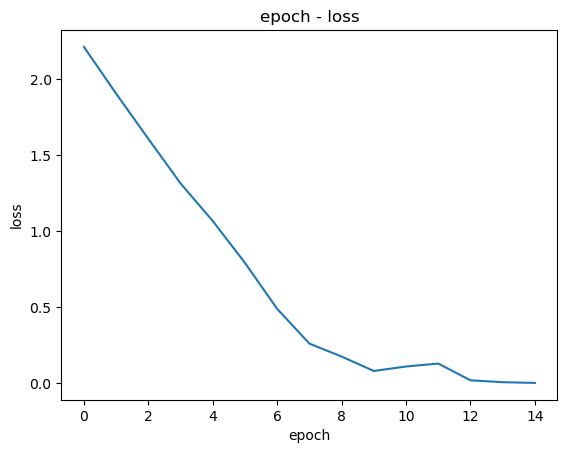

In [36]:
plt.plot(loss_values)
plt.title("epoch - loss")
plt.xlabel("epoch")
plt.ylabel("loss")

In [37]:
# test
conf_matrix = np.zeros(shape=(len(classes),len(classes)))
with torch.no_grad():
    for image, label in tqdm(test_loader):
        output = model(image)
        # value, index
        _, prediction = torch.max(output, 1)
        
        conf_matrix[label][prediction] += 1

  0%|          | 0/99 [00:00<?, ?it/s]

In [38]:
correct = 0
for i in range(len(conf_matrix)):
    correct += conf_matrix[i][i]
    
acc = correct / len(test_loader)
recall = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1))
precision = np.mean(np.diag(conf_matrix) / np.sum(conf_matrix, axis = 0))

In [39]:
print(f"overall accuracy is {acc:.2f}")
print(f"overall precision is {precision:.2f}")
print(f"overall recall is {recall:.2f}")

overall accuracy is 0.97
overall precision is 0.97
overall recall is 0.97


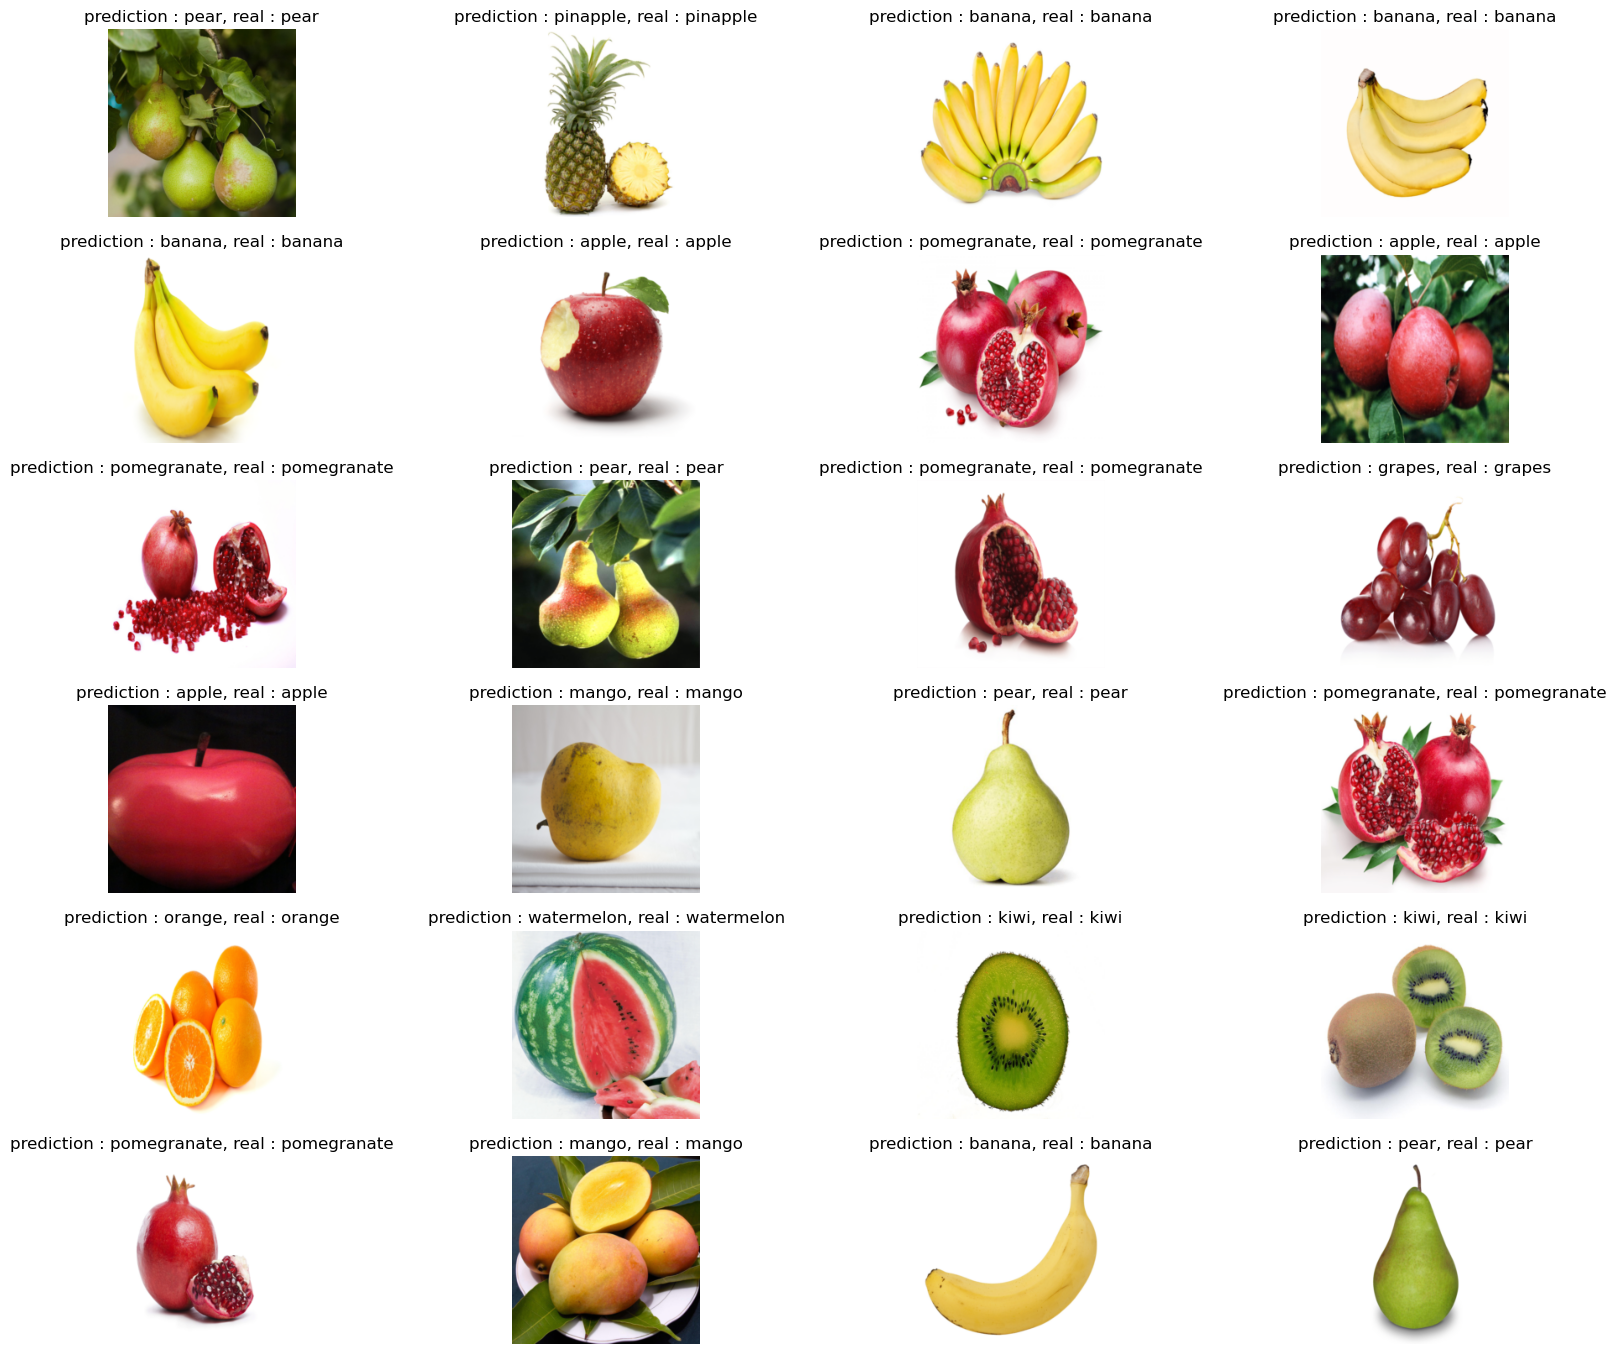

In [42]:
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=1,
                        shuffle=True)

# to unnormalize images, so we can see them better :)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

plt.figure(figsize=(20,20))
columns = 4
with torch.no_grad():

    for i, (image, label) in enumerate(test_loader):
        if i == 24:
            break
        plotImg = inv_normalize(image[0])
        plt.subplot(int(24 / columns + 1), columns, i + 1)
        plt.imshow((plotImg.permute(1,2,0)))
        plt.axis("off")
        output = model(image)
        _, prediction = torch.max(output, 1)
        plt.title(f"prediction : {classes[prediction]}, real : {classes[label]}")

In [41]:
torch.save(model, 'cnn.pth')